In [1]:
## Needed libraries

import pandas as pd
import numpy as np
import time, datetime
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
import os
import pandas as pd
import datetime

from cfd import CFDModel
from summit.utils.dataset import DataSet



In [2]:
## Required Classes and Functions

class TimeSeriesData:
    _data = [tuple]

    def __init__(self, date: datetime.date):
        self._date = date
        self._data = []
        self._last_idx = 0

    def append(self, time, value):
        # try:
        if isinstance(time, pd.Timestamp):
            self._data.append((time.to_pydatetime(), value))
        else:
            self._data.append((datetime.datetime.combine(self._date, time), value))
        # except TypeError:
        #     pass
        # except Exception as ex:
        #     print(ex)

    @property
    def data(self):
        return self._data

    def __len__(self):
        return len(self._data)

    def get_value(self, timestamp: datetime.datetime):
        surrounding_values = [None, self._data[0]]
        for i in range(self._last_idx, len(self._data)):
            if self._data[i][0] == timestamp:
                return self._data[i][1]
            if self._data[i][0] < timestamp and surrounding_values[0] is None:
                surrounding_values[0] = self._data[i]
                surrounding_values[1] = None
            if self._data[i][0] > timestamp:
                surrounding_values[1] = self._data[i]
                if surrounding_values[1] is not None:
                    self._last_idx = i
                    break
        if surrounding_values[0] is None:
            return surrounding_values[1][1]
        if surrounding_values[1] is None:
            return surrounding_values[0][1]

        dt1 = (timestamp - surrounding_values[0][0]).total_seconds()
        dt2 = (surrounding_values[1][0] - timestamp).total_seconds()
        dv = surrounding_values[1][1] - surrounding_values[0][1]

        return ((dt1 / (dt1 + dt2)) * dv) + surrounding_values[0][1]

IntProgress(value=0, max=1250)

    0.08% processed. Approximately 0 minutes and 2 seconds remaining.
	Predicted concentration: (0.00030732859643871845, 0.001333166832047394) mg/mL


    8.08% processed. Approximately 0 minutes and 51 seconds remaining.
	Predicted concentration: (156.855349123851, 0.5302609484022123) mg/mL


   16.08% processed. Approximately 0 minutes and 44 seconds remaining.
	Predicted concentration: (157.05039297717283, 52.05294881187427) mg/mL


   24.08% processed. Approximately 0 minutes and 40 seconds remaining.
	Predicted concentration: (157.05039297717283, 52.05294881187427) mg/mL


   32.08% processed. Approximately 0 minutes and 36 seconds remaining.
	Predicted concentration: (157.05039297717283, 52.05294881187427) mg/mL


   40.08% processed. Approximately 0 minutes and 32 seconds remaining.
	Predicted concentration: (157.05039297717283, 52.05294881187427) mg/mL


   48.08% processed. Approximately 0 minutes and 27 seconds remaining.
	Predicted concentration: (157.05039297717283, 52.05294881187427) mg/mL


   56.08% processed. Approximately 0 minutes and 23 seconds remaining.
	Predicted concentration: (157.05039297717283, 52.05294881187427) mg/mL


   64.08% processed. Approximately 0 minutes and 19 seconds remaining.
	Predicted concentration: (157.05039297717283, 52.05294881187427) mg/mL


   72.08% processed. Approximately 0 minutes and 14 seconds remaining.
	Predicted concentration: (157.05039297717283, 52.05294881187427) mg/mL


   80.08% processed. Approximately 0 minutes and 10 seconds remaining.
	Predicted concentration: (157.05039297717283, 52.05294881187427) mg/mL


   88.08% processed. Approximately 0 minutes and 6 seconds remaining.
	Predicted concentration: (157.05039297717283, 52.05294881187427) mg/mL


   96.08% processed. Approximately 0 minutes and 2 seconds remaining.
	Predicted concentration: (157.05039297717283, 52.05294881187427) mg/mL


52.05294881187427


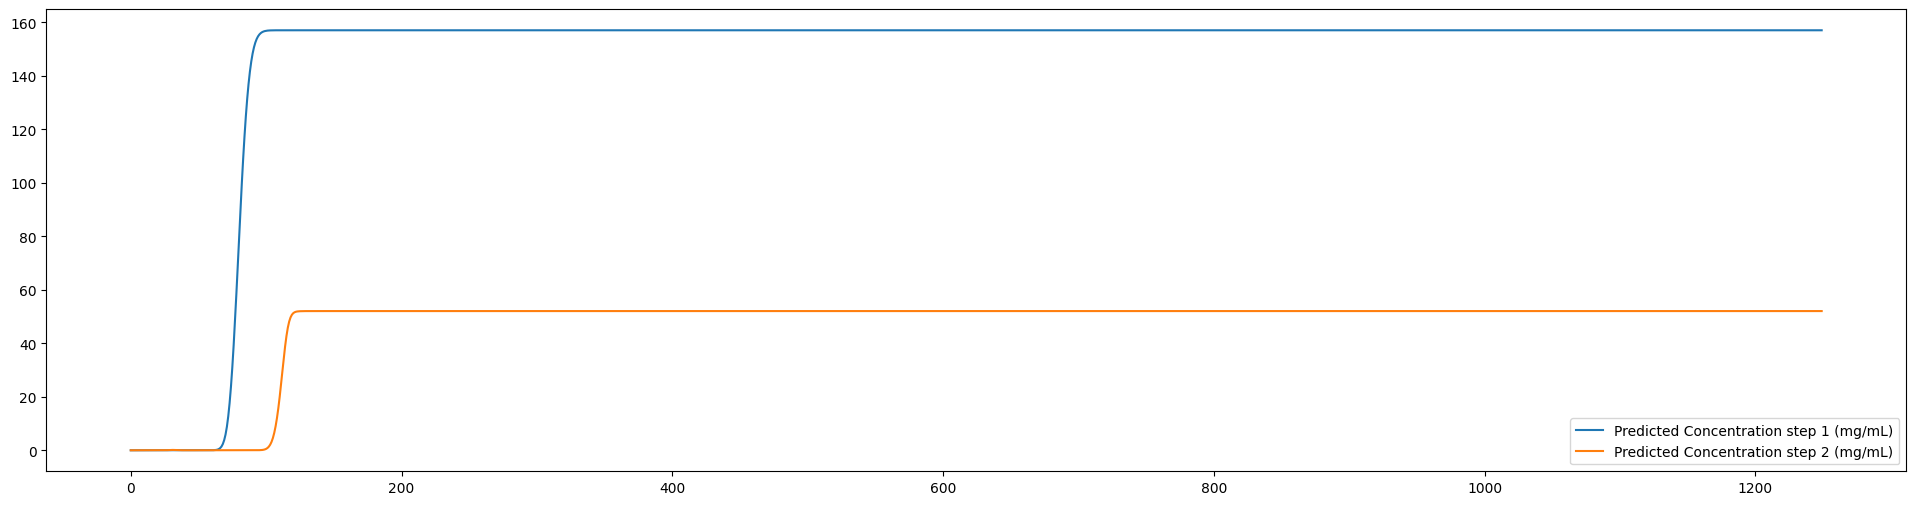

Done!


In [3]:
file_path = 'Digital_Twin_Dataset/Data/YumaDigi_Data.csv'
raw_data = DataSet.read_csv(file_path)
experiment_date = datetime.date(2022, 10, 3)

# Number of repetitions
n_repeats = 1250

# Time step increment in seconds
time_increment = 1  # 1 second

# Define the initial base time
base_time = datetime.datetime.strptime('2:17:52 PM', '%I:%M:%S %p').time()

# Function to create a list of datetime.time objects
def generate_time_series(start_time, n, increment):
    start_dt = datetime.datetime.combine(datetime.date(1, 1, 1), start_time)
    times = [start_dt + datetime.timedelta(seconds=i * increment) for i in range(n)]
    return [t.time() for t in times]

# Create a list of times for the current row
times = generate_time_series(base_time, n_repeats, time_increment)

# Iterate over each row in the input dataset, skipping the first row
for index, row in raw_data.iterrows():
        # Skip rows where the 'Output_Conc' column is already filled
    if not pd.isna(row['Output_Conc', 'DATA']):
        continue  # Skip the first row

        
    # Create DataFrame for the current row
    excel_data = pd.DataFrame({
        'acrylate time': times,
        'acrylate flow': [row['Acrylate', 'DATA']] * n_repeats,
        'fluoro time': times,
        'fluoro flow': [row['Fluoro', 'DATA']] * n_repeats,
        'cyclo time': times,
        'cyclo flow': [row['Cyclo', 'DATA']] * n_repeats,
        'temperature time': times,
        'temperature': [row['Temperature', 'DATA']] * n_repeats
    })
    
    ## Remove all negative flow rates
    
    acrylate_flowrate_conversion_function = lambda x: 0.0048 * x - 0.9793
    fluoro_flowrate_conversion_function = lambda x: 0.0038 * x - 0.7274
    cyclo_flowrate_conversion_function = lambda x: 0.0041 * x - 1.0507
    
    acrylate_flowrate_df = excel_data['acrylate flow'].apply(lambda x: x if x > 0 else 0)
    fluoro_flowrate_df = excel_data['fluoro flow'].apply(lambda x: x if x > 0 else 0)
    cyclo_flowrate_df = excel_data['cyclo flow'].apply(lambda x: x if x > 0 else 0)
    
    ## Temperature Data Preprocessing Step 1
    temperature_raw_timeseries_data = TimeSeriesData(experiment_date)    
    for i in range(len(excel_data['temperature'])):
        timestamp = excel_data['temperature time'][i]
        value = excel_data['temperature'][i]
        if timestamp != timestamp:
            continue
        if value != value:
            continue
        temperature_raw_timeseries_data.append(timestamp, value)
        
    
    ## Flowrate Data Preprocessing Step 1
    acrylate_timeseries_data = TimeSeriesData(experiment_date)
    fluoro_timeseries_data = TimeSeriesData(experiment_date)
    cyclo_timeseries_data = TimeSeriesData(experiment_date)
    
    for i in range(len(acrylate_flowrate_df)):
        timestamp = excel_data['acrylate time'][i]
        value = acrylate_flowrate_df[i]
        if timestamp != timestamp or value != value:
            continue
        acrylate_timeseries_data.append(timestamp, value)
    
    for i in range(len(fluoro_flowrate_df)):
        timestamp = excel_data['fluoro time'][i]
        value = fluoro_flowrate_df[i]
        if timestamp != timestamp or value != value:
            continue
        fluoro_timeseries_data.append(timestamp, value)
    
    for i in range(len(cyclo_flowrate_df)):
        timestamp = excel_data['cyclo time'][i]
        value = cyclo_flowrate_df[i]
        if timestamp != timestamp or value != value:
            continue
        cyclo_timeseries_data.append(timestamp, value)
        
        
    ## Merging data into a single dataframe
    
    merged_data = []
    
    largest_series = None
    
    if len(acrylate_timeseries_data) > len(fluoro_timeseries_data) and len(acrylate_timeseries_data) > len(cyclo_timeseries_data):
        largest_series = acrylate_timeseries_data
    else:
        if len(fluoro_timeseries_data) > len(cyclo_timeseries_data):
            largest_series = fluoro_timeseries_data
        else:
            largest_series = cyclo_timeseries_data
    
    start = 0
    max_count = len(largest_series)
    
    f = IntProgress(min=start, max=max_count)  # instantiate the bar
    display(f)  # display the bar
    
    for i in range(start, max_count):
        if largest_series == acrylate_timeseries_data:
            dt, value = acrylate_timeseries_data.data[i]
            acrylate_flow_value = value
            fluoro_flow_value = fluoro_timeseries_data.get_value(dt)
            cyclo_flow_value = cyclo_timeseries_data.get_value(dt)
            temperature_value = temperature_raw_timeseries_data.get_value(dt)
            merged_data.append((dt, acrylate_flow_value, fluoro_flow_value, cyclo_flow_value, temperature_value))
            if i % 100 == 0:
                f.value += 100
        elif largest_series == fluoro_timeseries_data:
            dt, value = fluoro_timeseries_data.data[i]
            fluoro_flow_value = value
            acrylate_flow_value = acrylate_timeseries_data.get_value(dt)
            cyclo_flow_value = cyclo_timeseries_data.get_value(dt)
            temperature_value = temperature_raw_timeseries_data.get_value(dt)
            merged_data.append((dt, acrylate_flow_value, fluoro_flow_value, cyclo_flow_value, temperature_value))
            if i % 100 == 0:
                f.value += 100
        else:
            dt, value = cyclo_timeseries_data.data[i]
            cyclo_flow_value = value
            acrylate_flow_value = acrylate_timeseries_data.get_value(dt)
            fluoro_flow_value = fluoro_timeseries_data.get_value(dt)
            temperature_value = temperature_raw_timeseries_data.get_value(dt)
            merged_data.append((dt, acrylate_flow_value, fluoro_flow_value, cyclo_flow_value, temperature_value))
            if i % 100 == 0:
                f.value += 100
    
    
    merged_df = pd.DataFrame()
    
    merged_df['Time'] = [value[0] for value in merged_data]
    merged_df['Acrylate'] = [value[1] for value in merged_data]
    merged_df['Fluoro'] = [value[2] for value in merged_data]
    merged_df['Cyclo'] = [value[3] for value in merged_data]
    merged_df['Temperature'] = [value[4] for value in merged_data]
    
    ## Run the simulation
    
    starting_acrylate_concentration = 1200
    starting_fluoro_concentration = 1000
    starting_cyclo_concentration = 1250
    
    reactor_1 = CFDModel(
        starting_acrylate_concentration,
        starting_fluoro_concentration,
        nx=600,
        Volume=10e-6,
        dt=0.005,
        # AxialDispersion=0.0005
    )
    reactor_2 = CFDModel(
        0,
        starting_cyclo_concentration,
        nx=600,
        Volume=5e-6,
        dt=0.005,
        ArrheniusFactor=11.3,
        ActivationEnergy=23681,
        MolecularWeight=346.18, # Check the molecular weight of the product
        # AxialDispersion=0.0005
    )
    np.seterr(all='raise')
    
    timestamps = merged_df['Time'].values
    acrylate_flowrates = merged_df['Acrylate']
    fluoro_flowrates = merged_df['Fluoro']
    cyclo_flowrates = merged_df['Cyclo']
    temperatures = merged_df['Temperature'].values
    
    number_of_samples = len(timestamps)
    
    reactor_predicted_output_concentrations = []
    
    try:
        last_step = datetime.datetime.now()
        last_timestamp = None
        time_difference = None
        # for i in range(71000):
        #     reactor_predicted_output_concentrations.append(np.NAN)
    
        for i in range(0, number_of_samples):
            timestamp = timestamps[i]
            acrylate_flowrate = acrylate_flowrates[i] * 1.667 * 10 ** -8
            fluoro_flowrate = fluoro_flowrates[i] * 1.667 * 10 ** -8
            cyclo_flowrate = cyclo_flowrates[i] * 1.667 * 10 ** -8
            temperature = temperatures[i]
    
            if last_timestamp is not None:
                time_difference = float(timestamp - last_timestamp) / 1000000000
            last_timestamp = timestamp
    
            reactor_1.set_temperature_in_degrees_celsius(temperature)
            reactor_1.species_A_flowrate = acrylate_flowrate
            reactor_1.species_B_flowrate = fluoro_flowrate
    
            reactor_1.update(dt=time_difference)
    
            reactor_2.set_temperature_in_degrees_celsius(25)
            reactor_2.species_A_flowrate = reactor_1.combined_flowrate
            reactor_2.species_B_flowrate = cyclo_flowrate
            reactor_2.species_A_stock_concentration = reactor_1.default_product_concentration
    
            reactor_2.update(dt=time_difference)
    
            predicted_concentration = (reactor_1.product_concentration, reactor_2.product_concentration)
    
            # if predicted_concentration != predicted_concentration:
            #     breakpoint()
            reactor_predicted_output_concentrations.append(predicted_concentration)
    
            if i % 100 == 0:
                time_delta = datetime.datetime.now() - last_step
                last_step = datetime.datetime.now()
                estimated_remaining_time = (number_of_samples - i) * (time_delta / 100)
                minutes_remaining = estimated_remaining_time.total_seconds() // 60
                seconds_remaining = estimated_remaining_time.total_seconds() % 60
                if minutes_remaining == 1:
                    print(
                        f'{((i + 1) / number_of_samples) * 100:8.4}% processed. Approximately {int(minutes_remaining)} minute and {int(seconds_remaining)} seconds remaining.')
                else:
                    print(
                        f'{((i + 1) / number_of_samples) * 100:8.4}% processed. Approximately {int(minutes_remaining)} minutes and {int(seconds_remaining)} seconds remaining.')
                print(f'\tPredicted concentration: {predicted_concentration} mg/mL')
        
        # Extract the second values from the last 10 tuples
        last_10_step2_values = [concentration[1] for concentration in reactor_predicted_output_concentrations[-10:]]
        
        # Calculate the average of these values
        avg_last_10_step2 = np.mean(last_10_step2_values)
        print(avg_last_10_step2)
        # Now, you can assign this average to the 'Output_Conc' column
        raw_data.loc[index, ('Output_Conc', 'DATA')] = avg_last_10_step2
        
        merged_df['Step 1 Concentration'] = [value[0] for value in reactor_predicted_output_concentrations]
        merged_df['Step 2 Concentration'] = [value[1] for value in reactor_predicted_output_concentrations]
        
        f = plt.figure()
        f.set_figwidth(24)
        f.set_figheight(6)
        
        plt.plot(merged_df['Step 1 Concentration'], label='Predicted Concentration step 1 (mg/mL)')
        plt.plot(merged_df['Step 2 Concentration'], label='Predicted Concentration step 2 (mg/mL)')
        plt.legend()
        plt.show()
        
    except KeyboardInterrupt:
        pass

# Save the final DataFrame back to the CSV file
raw_data.to_csv(file_path, header=True)

print('Done!')